### `Param`

Represents a static or dynamic parameter. Must have a name and a shape. If it has a value, can call `to()`.

### `Parametrized`

Given a `dict` with `Parametrized` objects' names as keys and their dynamic `Param`s as the values (either in the form of an args list, kwargs dict or flattened tensor), can unpack its values.

Given an args list or flattened tensor, knows how to pack 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functorch import vmap
import pytest
import torch

from caustic.parameter import Parameter
from caustic.parametrized import Parametrized

In [3]:
class C1(Parametrized):
    def __init__(self, name, p=None):
        super().__init__(name)
        self.add_param("p", p)

    def __call__(self, x):
        (p,) = self.unpack(x)
        print(f"[{self.name}] p is {p}")

In [4]:
with pytest.raises(ValueError):
    c1 = C1(1.0)

with pytest.raises(AttributeError):
    c1 = C1("c1", 1.0)

c1 = C1("c1")
print(c1)
print()

c1 = C1("c1", torch.tensor(0.0))
print(c1)
print()

C1(
    name='c1',
    static=[],
    dynamic=[p],
    x keys=[('c1': ['p'])]
)

C1(
    name='c1',
    static=[p],
    dynamic=[],
    x keys=[]
)



In [5]:
class C2(Parametrized):
    def __init__(self, name, d1, d2, p=None):
        super().__init__(name)
        self.d1 = d1
        self.d2 = d2
        self.add_param("p", p)

    def __call__(self, x):
        (p,) = self.unpack(x)
        print(f"[{self.name}] p is {p}")
        self.d1(x)
        self.d1(x)

In [6]:
c1a = c1b = C1("c1", torch.tensor(1.0))
c2 = C2("c2", c1a, c1b)
assert c2.d1 is c2.d2
print(c1)
print()

C1(
    name='c1',
    static=[p],
    dynamic=[],
    x keys=[]
)



In [7]:
c1a = C1("c1")
c1b = C1("c1")
with pytest.raises(KeyError):
    c2 = C2("c2", c1a, c1b)

c1a = c1b = C1("c1")
c2 = C2("c2", c1a, c1b)
assert c2.d1 is c2.d2
print(c2)
print()

c1a = C1("c1a")
c1b = C1("c1b")
c2 = C2("c2", c1a, c1b)
print(c2)
print()

# Repeatedly adding the same component should work fine
c = C1("c1_shared")
c2.c = c
c2.d1.c = c
c2.d2.c = c
c2.c = c
print(c2)
print()

C2(
    name='c2',
    static=[],
    dynamic=[p],
    x keys=[('c2': ['p']), ('c1': ['p'])]
)

C2(
    name='c2',
    static=[],
    dynamic=[p],
    x keys=[('c2': ['p']), ('c1a': ['p']), ('c1b': ['p'])]
)

C2(
    name='c2',
    static=[],
    dynamic=[p],
    x keys=[('c2': ['p']), ('c1a': ['p']), ('c1b': ['p']), ('c1_shared': ['p'])]
)



In [8]:
x = torch.tensor([1.0, 2.0, 3.0, 4.0])
print(c2.x_to_dict(x))
print()

c2(c2.x_to_dict(x))
print()

# Can pass kwargs, args or flattened tensor
c2({"c2": {"p": 1.0}, "c1a": [2.0], "c1b": torch.tensor(3.0)})

{'c2': tensor([1.]), 'c1a': tensor([2.]), 'c1b': tensor([3.]), 'c1_shared': tensor([4.])}

[c2] p is 1.0
[c1a] p is 2.0
[c1a] p is 2.0

[c2] p is 1.0
[c1a] p is 2.0
[c1a] p is 2.0


## Simple lensing simulator

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from math import pi

from functorch import vmap
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from caustic.cosmology import FlatLambdaCDM, h0_default
from caustic.lenses import SIE, Point, PseudoJaffe
from caustic.lenses import get_pix_magnification, get_pix_jacobian, get_magnification
from caustic.parametrized import Parametrized
from caustic.sources import Sersic
from caustic.utils import get_meshgrid

In [11]:
class Simulator(Parametrized):
    def __init__(
        self,
        res,
        n_pix,
        lens,
        src,
        z_s=None,
        upsample_factor=4,
        name: str = "sim",
    ):
        super().__init__(name)
        self.lens = lens
        self.src = src
        self.add_param("z_s", z_s)
        self.upsample_factor = upsample_factor

        self._thx_fine, self._thy_fine = get_meshgrid(
            res / upsample_factor, n_pix * upsample_factor, n_pix * upsample_factor
        )
        self.thx, self.thy = get_meshgrid(res, n_pix, n_pix)

    def __call__(self, x):
        x = self.x_to_dict(x)

        z_s = self.unpack(x)

        bx, by = self.lens.raytrace(self._thx_fine, self._thy_fine, z_s, x)
        mu_fine = self.src.brightness(bx, by, x)
        return F.avg_pool2d(mu_fine[None, None], self.upsample_factor)[0, 0]

In [12]:
# Set up cosmology, marking H0 as dynamic
cosmo = FlatLambdaCDM("cosmo", h0=None)
sie = SIE("sie", cosmo)
thx, thy = get_meshgrid(0.05, 100, 100)

In [13]:
x = [torch.tensor(x) for x in [0.9, 0.0, 0.0, 0.8, pi / 6, 1.5, 0.67]]
z_s = 2.1
sie.kappa(thx, thy, z_s, sie.x_to_dict(x))

tensor([[0.2352, 0.2372, 0.2393,  ..., 0.1976, 0.1958, 0.1940],
        [0.2379, 0.2400, 0.2422,  ..., 0.1999, 0.1980, 0.1962],
        [0.2406, 0.2428, 0.2451,  ..., 0.2022, 0.2003, 0.1984],
        ...,
        [0.1984, 0.2003, 0.2022,  ..., 0.2451, 0.2428, 0.2406],
        [0.1962, 0.1980, 0.1999,  ..., 0.2422, 0.2400, 0.2379],
        [0.1940, 0.1958, 0.1976,  ..., 0.2393, 0.2372, 0.2352]])

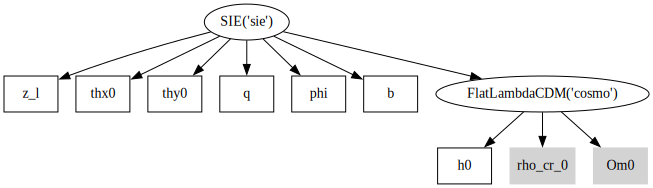

In [14]:
sie.get_graph(True, True)

caught exception:  "cannot add FlatLambdaCDM(name='cosmo', static=[rho_cr_0, Om0], dynamic=[h0], x keys=[('cosmo': ['h0'])]): a component with the name 'cosmo' already exists in the model DAG" 

Simulator(
    name='sim',
    static=[z_s],
    dynamic=[],
    x keys=[('sie': ['z_l']), ('cosmo': ['h0']), ('src': ['thx0', 'thy0'])]
) 

SIE(
    name='sie',
    static=[thx0, thy0, q, phi, b],
    dynamic=[z_l],
    x keys=[('sie': ['z_l']), ('cosmo': ['h0'])]
) 

FlatLambdaCDM(
    name='cosmo',
    static=[rho_cr_0, Om0],
    dynamic=[h0],
    x keys=[('cosmo': ['h0'])]
) 

Sersic(
    name='src',
    static=[q, phi, index, th_e, I_e],
    dynamic=[thx0, thy0],
    x keys=[('src': ['thx0', 'thy0'])]
) 

testing x size error checking:
caught exception:  0 flattened dynamic args were passed, but 4 are required 

running with valid argument vector

vmap shape check: torch.Size([10, 50, 50])


/Users/amcoogan/.pyenv/versions/3.10.3/envs/lens-3.10.3/lib/python3.10/site-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


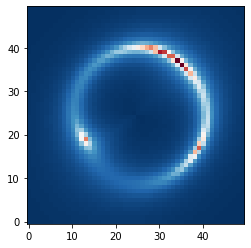

In [15]:
# Set up cosmology, marking H0 as dynamic
cosmo = FlatLambdaCDM("cosmo", h0=None)

# Static SIE args: z_l, thx0, thy0, q, phi, b
x_lens = torch.tensor([0.0, 0.0, 0.8, pi / 6, 1.5])
try:
    sie = SIE("cosmo", cosmo, None, *x_lens)
except KeyError as e:
    print("caught exception: ", e, "\n")

sie = SIE("sie", cosmo, None, *x_lens)

# Static Sersic args: q, phi, index, th_e, I_e
x_src = torch.tensor([0.6, pi / 4, 4.0, 2.5, 1.0])
src = Sersic("src", None, None, *x_src)

sim = Simulator(0.1, 50, sie, src, torch.tensor(0.8))
print(sim, "\n")
print(sie, "\n")
print(cosmo, "\n")
print(src, "\n")

print("testing x size error checking:")
x = torch.tensor([])
try:
    sim.x_to_dict(x)
except ValueError as e:
    print("caught exception: ", e, "\n")

print("running with valid argument vector")
x = torch.tensor([0.8, 0.7, 0.13, 0.04])
plt.imshow(sim(x), origin="lower", cmap="RdBu_r")
print()

print("vmap shape check:", vmap(sim)(x.repeat(10, 1)).shape)

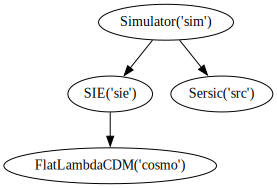

In [16]:
sim.get_graph()

In [17]:
sim.get_graph(True, True).render("~/Downloads/sim")

'~/Downloads/sim.pdf'

In [18]:
fov = 5.0
n_pix = 1_000
thx, thy = get_meshgrid(fov / n_pix, n_pix, n_pix)
z_s = torch.tensor(2.1)
x = torch.tensor([0.8, 0.7])

In [19]:
sie.magnification(thx, thy, z_s, sie.x_to_dict(x))

/Users/amcoogan/.pyenv/versions/3.10.3/envs/lens-3.10.3/lib/python3.10/site-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/Users/amcoogan/.pyenv/versions/3.10.3/envs/lens-3.10.3/lib/python3.10/site-packages/torch/_functorch/deprecated.py:85: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/doc

tensor([[1.8731, 1.8745, 1.8759,  ..., 1.6266, 1.6257, 1.6247],
        [1.8749, 1.8764, 1.8778,  ..., 1.6277, 1.6268, 1.6259],
        [1.8768, 1.8782, 1.8797,  ..., 1.6288, 1.6279, 1.6270],
        ...,
        [1.6270, 1.6279, 1.6288,  ..., 1.8797, 1.8782, 1.8768],
        [1.6259, 1.6268, 1.6277,  ..., 1.8778, 1.8764, 1.8749],
        [1.6247, 1.6257, 1.6266,  ..., 1.8759, 1.8745, 1.8731]],
       dtype=torch.float64)

## Testing out Connor's idea

The idea: would be nice to be able to call `Parametrized` functions with `x` or all the arguments explicitly. Basically `component.unpack(component.x_to_dict(x))` would be folded into a decorator `unpack`, which can check whether `x` or the args/kwargs were passed.

This cell initializes some lensing model components, evaluates them and shows they still work fine with `vmap`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import pi

from functorch import vmap
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from caustic.cosmology import FlatLambdaCDM, h0_default
from caustic.lenses import SIE, Point, PseudoJaffe
from caustic.lenses import get_pix_magnification, get_pix_jacobian, get_magnification
from caustic.parametrized import Parametrized
from caustic.sources import Sersic
from caustic.utils import get_meshgrid

In [3]:
def power_law_cdf(x, xmin, a):
    return (x > xmin)*(1 - (x / xmin)**(-a))

def inv_power_law_cdf(p, xmin, a):
    return xmin * (1 - p)**(- 1 / a)

def power_law_samples(N, xmin, a):
    return inv_power_law_cdf(torch.rand(N), xmin, a)

In [4]:
B = 5
Nhalos = 10
M_min = 1e6
alpha = 2.0

upsample = 3
n_pix = 128
res = 0.05  # fov / n_pix
fov = n_pix * res  # 5.0
thx, thy = get_meshgrid(res / upsample, n_pix * upsample, n_pix * upsample)

thx = thx.reshape(1, 1, (upsample * n_pix) ** 2, 1)
thy = thy.reshape(1, 1, (upsample * n_pix) ** 2, 1)

z_l = torch.tensor(1.0).view(1, 1, 1, 1)
thx0 = (torch.rand((B, Nhalos, 1, 1)) - 0.5) * fov * 1.2
thy0 = (torch.rand((B, Nhalos, 1, 1)) - 0.5) * fov * 1.2
k0 = (power_law_samples(B * Nhalos, M_min, alpha).view((B, Nhalos, 1, 1))) / (
    2 * pi * res * 10 * res * 1e15
)
scale_r = res * 10
core_r = torch.tensor(1 * res).view(1, 1, 1, 1)

cosmo = FlatLambdaCDM("cosmo", h0=None)
lens = PseudoJaffe("pj", cosmo)

In [5]:
z_s = None
x = [z_l, thx0, thy0, k0, core_r, scale_r, torch.tensor(0.67)]
kappa = lens.kappa(thx, thy, z_s, lens.x_to_dict(x)).sum(1).reshape(
    B, upsample * n_pix, upsample * n_pix
)[:, None]
kappa = F.avg_pool2d(kappa, upsample)[:, 0]

In [6]:
from collections import OrderedDict

class Packed(OrderedDict):
    """
    Wrapper for x so other functions can check its type.
    """
    ...

In [7]:
import functools
import inspect


def unpack(n_leading_args=0):
    # TODO: handle case of having leading args in kwargs
    def decorator(method):
        @functools.wraps(method)
        def wrapped(self, *args, **kwargs):
            leading_args = args[:n_leading_args]

            if isinstance(args[n_leading_args], Packed):
                x = args[n_leading_args]
            else:
                # TODO: change x_to_dict to pack, and return a Packed object
                x = Packed(self.x_to_dict(args[n_leading_args:]))

#             print(x)

            return method(self, *leading_args, *self.unpack(x), x)

        return wrapped

    return decorator

In [8]:
from math import pi
from typing import Any, Optional

import torch
from torch import Tensor

from caustic.cosmology import Cosmology
from caustic.utils import translate_rotate
from caustic.lenses.base import ThinLens


class PseudoJaffe(ThinLens):
    """
    Notes:
        Based on `Eliasdottir et al 2007 <https://arxiv.org/abs/0710.5636>`_ and
        the `lenstronomy` source code.
    """

    def __init__(
        self,
        name: str,
        cosmology: Cosmology,
        z_l: Optional[Tensor] = None,
        thx0: Optional[Tensor] = None,
        thy0: Optional[Tensor] = None,
        kappa_0: Optional[Tensor] = None,
        th_core: Optional[Tensor] = None,
        th_s: Optional[Tensor] = None,
        s: float = 0.0,
    ):
        super().__init__(name, cosmology, z_l)

        self.add_param("thx0", thx0)
        self.add_param("thy0", thy0)
        self.add_param("kappa_0", kappa_0)
        self.add_param("th_core", th_core)
        self.add_param("th_s", th_s)
        self.s = s

    def mass_enclosed_2d(self, th, z_s, x: Optional[dict[str, Any]] = None):
        z_l, thx0, thy0, kappa_0, th_core, th_s = self.unpack(x)

        th = th + self.s
        Sigma_0 = kappa_0 * self.cosmology.Sigma_cr(z_l, z_s, x)
        return (
            2
            * pi
            * Sigma_0
            * th_core
            * th_s
            / (th_s - th_core)
            * (
                (th_core**2 + th**2).sqrt()
                - th_core
                - (th_s**2 + th**2).sqrt()
                + th_s
            )
        )

    @staticmethod
    def kappa_0(
        z_l,
        z_s,
        rho_0,
        th_core,
        th_s,
        cosmology: Cosmology,
        x: Optional[dict[str, Any]] = None,
    ):
        return (
            pi
            * rho_0
            * th_core
            * th_s
            / (th_core + th_s)
            / cosmology.Sigma_cr(z_l, z_s, x)
        )

    def alpha(
        self, thx: Tensor, thy: Tensor, z_s: Tensor, x: Optional[dict[str, Any]] = None
    ) -> tuple[Tensor, Tensor]:
        z_l, thx0, thy0, kappa_0, th_core, th_s = self.unpack(x)

        thx, thy = translate_rotate(thx, thy, thx0, thy0)
        th = (thx**2 + thy**2).sqrt() + self.s
        f = th / th_core / (1 + (1 + (th / th_core) ** 2).sqrt()) - th / th_s / (
            1 + (1 + (th / th_s) ** 2).sqrt()
        )
        alpha = 2 * kappa_0 * th_core * th_s / (th_s - th_core) * f
        ax = alpha * thx / th
        ay = alpha * thy / th
        return ax, ay

    def Psi(
        self, thx: Tensor, thy: Tensor, z_s: Tensor, x: Optional[dict[str, Any]] = None
    ) -> Tensor:
        """
        Lensing potential (eq. A18).
        """
        z_l, thx0, thy0, kappa_0, th_core, th_s = self.unpack(x)

        thx, thy = translate_rotate(thx, thy, thx0, thy0)
        th = (thx**2 + thy**2).sqrt() + self.s
        coeff = -2 * kappa_0 * th_core * th_s / (th_s - th_core)
        return coeff * (
            (th_s**2 + th**2).sqrt()
            - (th_core**2 + th**2).sqrt()
            + th_core * (th_core + (th_core**2 + th**2).sqrt()).log()
            - th_s * (th_s + (th_s**2 + th**2).sqrt()).log()
        )

    @unpack(3)
    def kappa(
        self,
        thx: Tensor,
        thy: Tensor,
        z_s: Tensor,
        z_l,
        thx0,
        thy0,
        kappa_0,
        th_core,
        th_s,
        x,
    ) -> Tensor:
        """
        Projected mass density (eq. A6).
        """
        z_l, thx0, thy0, kappa_0, th_core, th_s = self.unpack(x)

        thx, thy = translate_rotate(thx, thy, thx0, thy0)
        th = (thx**2 + thy**2).sqrt() + self.s
        coeff = kappa_0 * th_core * th_s / (th_s - th_core)
        return coeff * (
            1 / (th_core**2 + th**2).sqrt() - 1 / (th_s**2 + th**2).sqrt()
        )

In [9]:
cosmo = FlatLambdaCDM("cosmo", h0=None)
lens = PseudoJaffe("pf", cosmo)

In [ ]:
x = [...]
lens.raytrace(thx, thy, z_s, lens.x_to_dict(x))
# Inside raytrace:
#     thx0, thy0, q, phi, b, t = lens.unpack(x)

In [ ]:
lens.raytrace(thx, thy, z_s, thx0, thy0, q, phi, b, t, h0)

In [ ]:
lens.raytrace(thx, thy, z_s, x)

In [ ]:
# Make x typed
# @unpack

In [10]:
%%timeit
# Option 1: pass all the args explicitly
lens.kappa(
    thx, thy, z_s, z_l, thx0, thy0, k0, core_r, scale_r, torch.tensor(0.67)
).shape

ValueError: invalid argument type: must be a dict containing key pf and value containing args as list or flattened tensor, or kwargs

In [38]:
%%timeit
# Option 2: pass x
x = Packed({"pf": [z_l, thx0, thy0, k0, core_r, scale_r], "cosmo": torch.tensor(0.67)})
lens.kappa(thx, thy, z_s, x).shape

Packed([('pf', [tensor([[[[1.]]]]), tensor([[[[ 0.2660]],

         [[ 3.1659]],

         [[ 2.8824]],

         [[ 0.8943]],

         [[ 1.4819]],

         [[ 0.8825]],

         [[-2.9721]],

         [[ 2.6163]],

         [[ 0.4589]],

         [[ 0.4264]]],


        [[[-0.0134]],

         [[-1.2602]],

         [[ 0.9803]],

         [[-2.4714]],

         [[ 0.5049]],

         [[ 3.4291]],

         [[ 0.0962]],

         [[-2.7783]],

         [[ 1.3905]],

         [[-3.0733]]],


        [[[ 1.9004]],

         [[ 2.7610]],

         [[ 2.0331]],

         [[ 2.6588]],

         [[-1.6440]],

         [[ 1.6147]],

         [[ 1.0800]],

         [[ 0.2557]],

         [[ 0.6444]],

         [[ 1.0775]]],


        [[[-1.7852]],

         [[ 0.6883]],

         [[ 2.3647]],

         [[-1.1713]],

         [[-3.4137]],

         [[ 1.6030]],

         [[ 1.5034]],

         [[-2.7110]],

         [[-3.6119]],

         [[-0.7586]]],


        [[[ 1.3912]],

         [[ 2

Packed([('pf', [tensor([[[[1.]]]]), tensor([[[[ 0.2660]],

         [[ 3.1659]],

         [[ 2.8824]],

         [[ 0.8943]],

         [[ 1.4819]],

         [[ 0.8825]],

         [[-2.9721]],

         [[ 2.6163]],

         [[ 0.4589]],

         [[ 0.4264]]],


        [[[-0.0134]],

         [[-1.2602]],

         [[ 0.9803]],

         [[-2.4714]],

         [[ 0.5049]],

         [[ 3.4291]],

         [[ 0.0962]],

         [[-2.7783]],

         [[ 1.3905]],

         [[-3.0733]]],


        [[[ 1.9004]],

         [[ 2.7610]],

         [[ 2.0331]],

         [[ 2.6588]],

         [[-1.6440]],

         [[ 1.6147]],

         [[ 1.0800]],

         [[ 0.2557]],

         [[ 0.6444]],

         [[ 1.0775]]],


        [[[-1.7852]],

         [[ 0.6883]],

         [[ 2.3647]],

         [[-1.1713]],

         [[-3.4137]],

         [[ 1.6030]],

         [[ 1.5034]],

         [[-2.7110]],

         [[-3.6119]],

         [[-0.7586]]],


        [[[ 1.3912]],

         [[ 2

Packed([('pf', [tensor([[[[1.]]]]), tensor([[[[ 0.2660]],

         [[ 3.1659]],

         [[ 2.8824]],

         [[ 0.8943]],

         [[ 1.4819]],

         [[ 0.8825]],

         [[-2.9721]],

         [[ 2.6163]],

         [[ 0.4589]],

         [[ 0.4264]]],


        [[[-0.0134]],

         [[-1.2602]],

         [[ 0.9803]],

         [[-2.4714]],

         [[ 0.5049]],

         [[ 3.4291]],

         [[ 0.0962]],

         [[-2.7783]],

         [[ 1.3905]],

         [[-3.0733]]],


        [[[ 1.9004]],

         [[ 2.7610]],

         [[ 2.0331]],

         [[ 2.6588]],

         [[-1.6440]],

         [[ 1.6147]],

         [[ 1.0800]],

         [[ 0.2557]],

         [[ 0.6444]],

         [[ 1.0775]]],


        [[[-1.7852]],

         [[ 0.6883]],

         [[ 2.3647]],

         [[-1.1713]],

         [[-3.4137]],

         [[ 1.6030]],

         [[ 1.5034]],

         [[-2.7110]],

         [[-3.6119]],

         [[-0.7586]]],


        [[[ 1.3912]],

         [[ 2

Packed([('pf', [tensor([[[[1.]]]]), tensor([[[[ 0.2660]],

         [[ 3.1659]],

         [[ 2.8824]],

         [[ 0.8943]],

         [[ 1.4819]],

         [[ 0.8825]],

         [[-2.9721]],

         [[ 2.6163]],

         [[ 0.4589]],

         [[ 0.4264]]],


        [[[-0.0134]],

         [[-1.2602]],

         [[ 0.9803]],

         [[-2.4714]],

         [[ 0.5049]],

         [[ 3.4291]],

         [[ 0.0962]],

         [[-2.7783]],

         [[ 1.3905]],

         [[-3.0733]]],


        [[[ 1.9004]],

         [[ 2.7610]],

         [[ 2.0331]],

         [[ 2.6588]],

         [[-1.6440]],

         [[ 1.6147]],

         [[ 1.0800]],

         [[ 0.2557]],

         [[ 0.6444]],

         [[ 1.0775]]],


        [[[-1.7852]],

         [[ 0.6883]],

         [[ 2.3647]],

         [[-1.1713]],

         [[-3.4137]],

         [[ 1.6030]],

         [[ 1.5034]],

         [[-2.7110]],

         [[-3.6119]],

         [[-0.7586]]],


        [[[ 1.3912]],

         [[ 2

Packed([('pf', [tensor([[[[1.]]]]), tensor([[[[ 0.2660]],

         [[ 3.1659]],

         [[ 2.8824]],

         [[ 0.8943]],

         [[ 1.4819]],

         [[ 0.8825]],

         [[-2.9721]],

         [[ 2.6163]],

         [[ 0.4589]],

         [[ 0.4264]]],


        [[[-0.0134]],

         [[-1.2602]],

         [[ 0.9803]],

         [[-2.4714]],

         [[ 0.5049]],

         [[ 3.4291]],

         [[ 0.0962]],

         [[-2.7783]],

         [[ 1.3905]],

         [[-3.0733]]],


        [[[ 1.9004]],

         [[ 2.7610]],

         [[ 2.0331]],

         [[ 2.6588]],

         [[-1.6440]],

         [[ 1.6147]],

         [[ 1.0800]],

         [[ 0.2557]],

         [[ 0.6444]],

         [[ 1.0775]]],


        [[[-1.7852]],

         [[ 0.6883]],

         [[ 2.3647]],

         [[-1.1713]],

         [[-3.4137]],

         [[ 1.6030]],

         [[ 1.5034]],

         [[-2.7110]],

         [[-3.6119]],

         [[-0.7586]]],


        [[[ 1.3912]],

         [[ 2

Packed([('pf', [tensor([[[[1.]]]]), tensor([[[[ 0.2660]],

         [[ 3.1659]],

         [[ 2.8824]],

         [[ 0.8943]],

         [[ 1.4819]],

         [[ 0.8825]],

         [[-2.9721]],

         [[ 2.6163]],

         [[ 0.4589]],

         [[ 0.4264]]],


        [[[-0.0134]],

         [[-1.2602]],

         [[ 0.9803]],

         [[-2.4714]],

         [[ 0.5049]],

         [[ 3.4291]],

         [[ 0.0962]],

         [[-2.7783]],

         [[ 1.3905]],

         [[-3.0733]]],


        [[[ 1.9004]],

         [[ 2.7610]],

         [[ 2.0331]],

         [[ 2.6588]],

         [[-1.6440]],

         [[ 1.6147]],

         [[ 1.0800]],

         [[ 0.2557]],

         [[ 0.6444]],

         [[ 1.0775]]],


        [[[-1.7852]],

         [[ 0.6883]],

         [[ 2.3647]],

         [[-1.1713]],

         [[-3.4137]],

         [[ 1.6030]],

         [[ 1.5034]],

         [[-2.7110]],

         [[-3.6119]],

         [[-0.7586]]],


        [[[ 1.3912]],

         [[ 2

Packed([('pf', [tensor([[[[1.]]]]), tensor([[[[ 0.2660]],

         [[ 3.1659]],

         [[ 2.8824]],

         [[ 0.8943]],

         [[ 1.4819]],

         [[ 0.8825]],

         [[-2.9721]],

         [[ 2.6163]],

         [[ 0.4589]],

         [[ 0.4264]]],


        [[[-0.0134]],

         [[-1.2602]],

         [[ 0.9803]],

         [[-2.4714]],

         [[ 0.5049]],

         [[ 3.4291]],

         [[ 0.0962]],

         [[-2.7783]],

         [[ 1.3905]],

         [[-3.0733]]],


        [[[ 1.9004]],

         [[ 2.7610]],

         [[ 2.0331]],

         [[ 2.6588]],

         [[-1.6440]],

         [[ 1.6147]],

         [[ 1.0800]],

         [[ 0.2557]],

         [[ 0.6444]],

         [[ 1.0775]]],


        [[[-1.7852]],

         [[ 0.6883]],

         [[ 2.3647]],

         [[-1.1713]],

         [[-3.4137]],

         [[ 1.6030]],

         [[ 1.5034]],

         [[-2.7110]],

         [[-3.6119]],

         [[-0.7586]]],


        [[[ 1.3912]],

         [[ 2

Packed([('pf', [tensor([[[[1.]]]]), tensor([[[[ 0.2660]],

         [[ 3.1659]],

         [[ 2.8824]],

         [[ 0.8943]],

         [[ 1.4819]],

         [[ 0.8825]],

         [[-2.9721]],

         [[ 2.6163]],

         [[ 0.4589]],

         [[ 0.4264]]],


        [[[-0.0134]],

         [[-1.2602]],

         [[ 0.9803]],

         [[-2.4714]],

         [[ 0.5049]],

         [[ 3.4291]],

         [[ 0.0962]],

         [[-2.7783]],

         [[ 1.3905]],

         [[-3.0733]]],


        [[[ 1.9004]],

         [[ 2.7610]],

         [[ 2.0331]],

         [[ 2.6588]],

         [[-1.6440]],

         [[ 1.6147]],

         [[ 1.0800]],

         [[ 0.2557]],

         [[ 0.6444]],

         [[ 1.0775]]],


        [[[-1.7852]],

         [[ 0.6883]],

         [[ 2.3647]],

         [[-1.1713]],

         [[-3.4137]],

         [[ 1.6030]],

         [[ 1.5034]],

         [[-2.7110]],

         [[-3.6119]],

         [[-0.7586]]],


        [[[ 1.3912]],

         [[ 2

Packed([('pf', [tensor([[[[1.]]]]), tensor([[[[ 0.2660]],

         [[ 3.1659]],

         [[ 2.8824]],

         [[ 0.8943]],

         [[ 1.4819]],

         [[ 0.8825]],

         [[-2.9721]],

         [[ 2.6163]],

         [[ 0.4589]],

         [[ 0.4264]]],


        [[[-0.0134]],

         [[-1.2602]],

         [[ 0.9803]],

         [[-2.4714]],

         [[ 0.5049]],

         [[ 3.4291]],

         [[ 0.0962]],

         [[-2.7783]],

         [[ 1.3905]],

         [[-3.0733]]],


        [[[ 1.9004]],

         [[ 2.7610]],

         [[ 2.0331]],

         [[ 2.6588]],

         [[-1.6440]],

         [[ 1.6147]],

         [[ 1.0800]],

         [[ 0.2557]],

         [[ 0.6444]],

         [[ 1.0775]]],


        [[[-1.7852]],

         [[ 0.6883]],

         [[ 2.3647]],

         [[-1.1713]],

         [[-3.4137]],

         [[ 1.6030]],

         [[ 1.5034]],

         [[-2.7110]],

         [[-3.6119]],

         [[-0.7586]]],


        [[[ 1.3912]],

         [[ 2

Packed([('pf', [tensor([[[[1.]]]]), tensor([[[[ 0.2660]],

         [[ 3.1659]],

         [[ 2.8824]],

         [[ 0.8943]],

         [[ 1.4819]],

         [[ 0.8825]],

         [[-2.9721]],

         [[ 2.6163]],

         [[ 0.4589]],

         [[ 0.4264]]],


        [[[-0.0134]],

         [[-1.2602]],

         [[ 0.9803]],

         [[-2.4714]],

         [[ 0.5049]],

         [[ 3.4291]],

         [[ 0.0962]],

         [[-2.7783]],

         [[ 1.3905]],

         [[-3.0733]]],


        [[[ 1.9004]],

         [[ 2.7610]],

         [[ 2.0331]],

         [[ 2.6588]],

         [[-1.6440]],

         [[ 1.6147]],

         [[ 1.0800]],

         [[ 0.2557]],

         [[ 0.6444]],

         [[ 1.0775]]],


        [[[-1.7852]],

         [[ 0.6883]],

         [[ 2.3647]],

         [[-1.1713]],

         [[-3.4137]],

         [[ 1.6030]],

         [[ 1.5034]],

         [[-2.7110]],

         [[-3.6119]],

         [[-0.7586]]],


        [[[ 1.3912]],

         [[ 2

In [39]:
lens.x_to_dict(x)

{'pf': [tensor([[[[1.]]]]),
  tensor([[[[ 0.2660]],
  
           [[ 3.1659]],
  
           [[ 2.8824]],
  
           [[ 0.8943]],
  
           [[ 1.4819]],
  
           [[ 0.8825]],
  
           [[-2.9721]],
  
           [[ 2.6163]],
  
           [[ 0.4589]],
  
           [[ 0.4264]]],
  
  
          [[[-0.0134]],
  
           [[-1.2602]],
  
           [[ 0.9803]],
  
           [[-2.4714]],
  
           [[ 0.5049]],
  
           [[ 3.4291]],
  
           [[ 0.0962]],
  
           [[-2.7783]],
  
           [[ 1.3905]],
  
           [[-3.0733]]],
  
  
          [[[ 1.9004]],
  
           [[ 2.7610]],
  
           [[ 2.0331]],
  
           [[ 2.6588]],
  
           [[-1.6440]],
  
           [[ 1.6147]],
  
           [[ 1.0800]],
  
           [[ 0.2557]],
  
           [[ 0.6444]],
  
           [[ 1.0775]]],
  
  
          [[[-1.7852]],
  
           [[ 0.6883]],
  
           [[ 2.3647]],
  
           [[-1.1713]],
  
           [[-3.4137]],
  
           [[ 1